In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [ ]:
input_dim = 784     # Size of input image
hidden_nodes = 256  # Number of hidden nodes
latent_dim = 2      # Latent space size i.e dimension of mean and standard_deviation

batch_size = 100           
epsilon_std = 1.0   # Parameter which helps in sampling from latent space z
epochs = 50

In [ ]:
# Encoder architecture
inp = Input(shape=(input_dim,))                     # placeholder for input image
hidden = Dense(hidden_nodes, activation='relu')(inp)     #First layer of encoder is a fully connected layer
mean = Dense(latent_dim)(hidden)                     # fully connected layer which calculates value for latent dimension mean
std = Dense(latent_dim)(hidden)                  # fully connected layer which calculates value for latent dimension std_deviation

In [ ]:
# Sampling function which produces a sample using the mean and std_deviation for the decoder to decode
def sampling_function(args):
    mean, std = args
    epsilon = K.random_normal(shape=(K.shape(mean)[0], latent_dim), mean = 0, stddev = epsilon_std)
    return mean + K.exp(std/2) * epsilon

In [ ]:
#  Lambda wraps arbitrary expression as a Layer object. This serves to be an input to the decoder.
# Reference https://keras.io/layers/core/#lambda
z = Lambda(sampling_function, output_shape=(latent_dim,))([mean, std])

In [ ]:
# Decoder Architecture
decoder_hidden = Dense(hidden_nodes, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
hidden_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(hidden_decoded)

In [ ]:
# Creating a VAE model
vae = Model(x, x_decoded_mean)

#Creating an encoder model
encoder = Model(x, z)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)

# Creating a decoder model
generator = Model(decoder_input, _x_decoded_mean)

In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)                # reconstruction loss
    kl_loss = - 0.5 * K.sum(1 + std - K.square(z) - K.exp(std), axis=-1)    #Kl divergence loss, this meaures the difference between the current enocded value(latent space) with the actual value. This should be as low as possible.
    return K.mean(xent_loss + kl_loss)

vae.compile(optimizer = 'rmsprop',loss = vae_loss)
vae.summary()       #structure of the whole variational autoencoder

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          200960      input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            514         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 2)            514         dense_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
# load training as well as test data
(x_train,y_train),(x_test,y_test) = mnist.load_data()

# print("Training Data Shape X:", x_train.shape," y: ", y_train.shape)
# print("Test Data Shape X:", x_test.shape," y: ", y_test.shape)

# Normalizing the values of training and test set
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

# converting data into specific shape so that it could be fed into the model i.e flattening each example from (28,28) to (784) size 
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))

x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

In [ ]:
# training for 100 epochs
vae.fit(x_train,x_train,
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 121us/step - loss: 159.7706 - val_loss: 159.3867
Epoch 2/100
60000/60000 [==============================] - 7s 121us/step - loss: 158.8421 - val_loss: 158.6675
Epoch 3/100
60000/60000 [==============================] - 7s 123us/step - loss: 158.0390 - val_loss: 158.0878
Epoch 4/100
60000/60000 [==============================] - 7s 123us/step - loss: 157.3886 - val_loss: 157.4683
Epoch 5/100
60000/60000 [==============================] - 7s 124us/step - loss: 156.7909 - val_loss: 157.4232
Epoch 6/100
60000/60000 [==============================] - 7s 124us/step - loss: 156.2941 - val_loss: 156.3929
Epoch 7/100
60000/60000 [==============================] - 7s 123us/step - loss: 155.8245 - val_loss: 156.5685
Epoch 8/100
60000/60000 [==============================] - 7s 122us/step - loss: 155.4076 - val_loss: 155.8043
Epoch 9/100
60000/60000 [==============================] - 7s 

In [ ]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

print(figure.shape)

(420, 420)


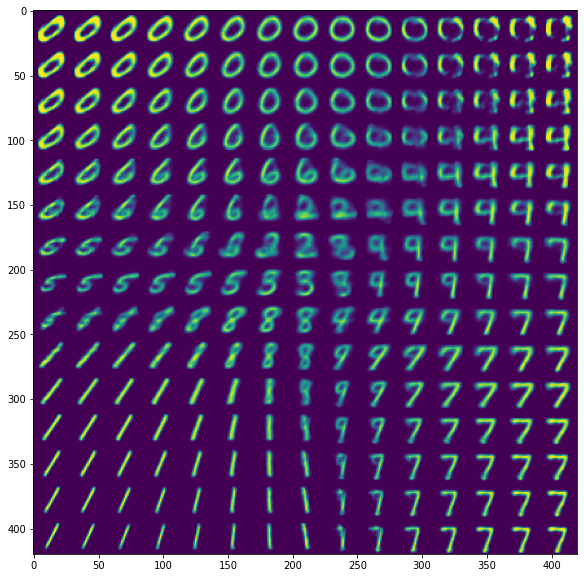

In [ ]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()